**Chapter 2 : End-to-End Machine Learning Project**

In [ ]:
# Fetching the data 
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" 
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): 
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz") 
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path) 
  housing_tgz.extractall(path=housing_path) 
  housing_tgz.close()
fetch_housing_data()
# Data is downloaded in the directory


In [ ]:
# Load the dataset 
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)
housing = load_housing_data()


In [ ]:
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# Are there any missing values?
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [ ]:
housing["ocean_proximity"].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


1) According the histogram below the median income value stops at 15. The numbers represent roughly 1 = 10,000

2) Median house value was capped at $500,000 which is a problem as it is the label that I am trying to predict 

3) The data has various scales 

4) The histograms are tail heavy meaning they extend more to the right of the mean of the median compared to the left (Need to transform these into bell-shaped attributes)

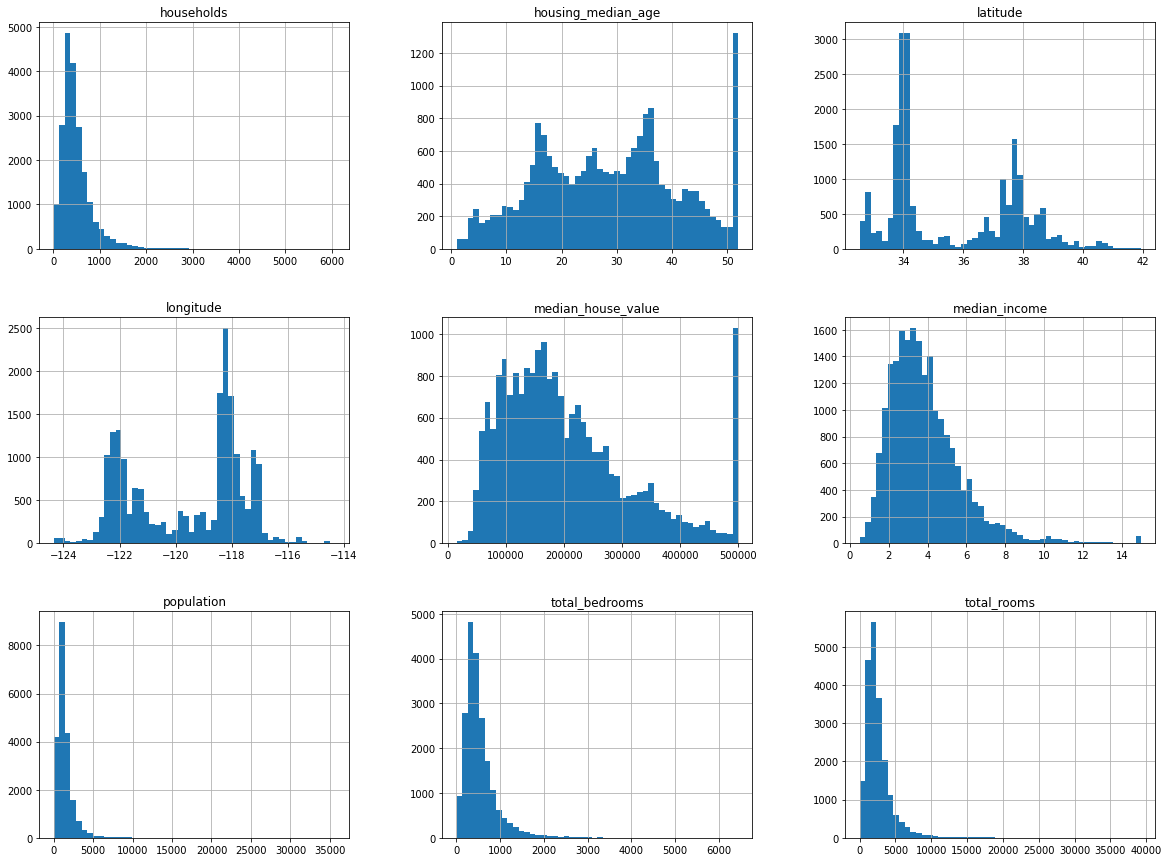

In [ ]:
# Plot the histogram of the numerical attributes 
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Here the data is split into the train and test split randomly which is fine for the purposes of the small project but introduces sampling bias if implemented in a much larger dataset with real world applications 

For example, when doing surveys for a 1000 people you want to get surveys from an equal distribution of individuals that are a representative of the population that the surveys are carried out.

This method is called *stratified sampling* i.e. the population is divided into homogenous subgroups called *strata*. The right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. Without it you run the risk of having skewed or biases data. 

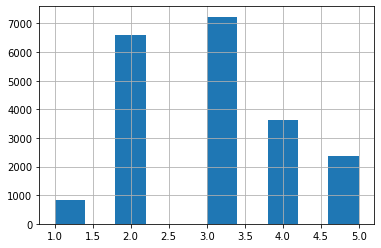

In [ ]:
# You may want to ensure the test set is a representative of the various categories of incomes in the whole dataset.
# It is important to have sufficient amount of instances in your dataset for each stratum or it could result in biased data 
# Create an income category 
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0.,1.5,3.0,4.5,6., np.inf],
                               labels = [1,2,3,4,5])
housing["income_cat"].hist()

In [ ]:
# Carry out Stratified Sampling 
# Data is now proportional to the overall dataset 
from sklearn.model_selection import StratifiedShuffleSplit 

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratSplit.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
# Remove the income_cat attribute 
for set_ in (strat_train_set, strat_test_set): 
  set_.drop("income_cat", axis=1, inplace=True)

Visualising the data to gain insights 

In [ ]:
# Remember to create a copy of the dataset so you can play around with it 
housing = strat_train_set.copy()

<function matplotlib.pyplot.legend>

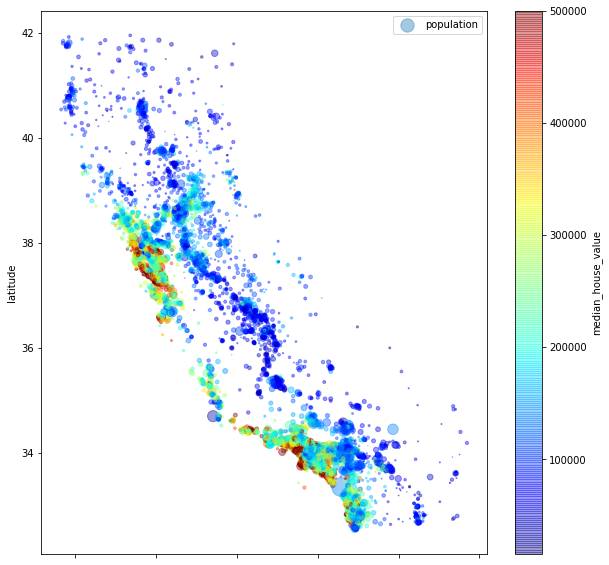

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4, s=housing["population"]/100, label="population", figsize=(10,10), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend

Seems like the housing prices are higher the closer they are to the sea which makes sense. 

In [ ]:
# Looking for Correlations 

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coeeficient ranges from -1 to 1

When it is close to 1 (strong positive correlation) it means that the median house value tends to go up when the median income of the area goes up .

When it is close to -1 then there is a strong negative correlation 

Coefficients close to 0 mean there is no linear correlation 

**NOTE:** the correlation coefficient only measures linear correlations and may miss out on non-linear relationships 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1130f3710>,
      dtype=object)

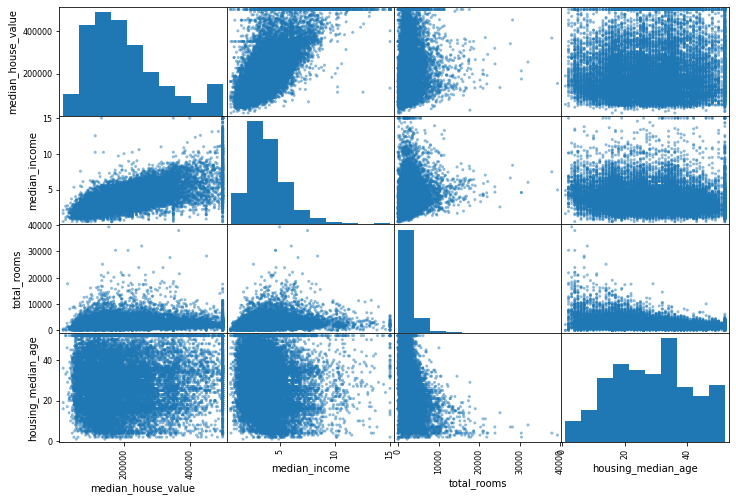

In [ ]:
# Plotting correlation 
from pandas.plotting import scatter_matrix 

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

It seems like median house value and the media income are highly correlated so lets plot both of them to get a better understanding 

The plot below highlights that the correlation is indeed very strong. Notice the price cap which forms a line at 500,000, 350,000, 225,000 which are quirks that need to be rectified in order to make the machine learning model perform well.

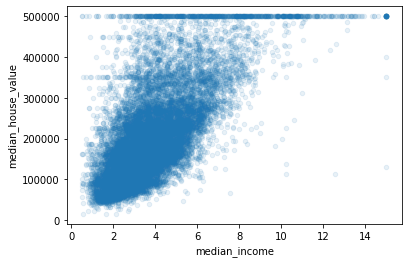

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

Before preparing the data for ML algorithms an important thing to consider is the atributes of the data 

 

1.   Total number of bedrooms in a district is not very useful 
2.   Total number of bedrooms itself is not useful 
3.   Population per household seems odd as well

**Instead lets create more logical and useful attributes such as rooms per household, population per household ad bedrroms per room**



In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] 
housing["population_per_household"]=housing["population"]/housing["households"]

In [ ]:
corr_matrix2 = housing.corr()
corr_matrix2["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

**Prepare the Data for ML Algorithms**

In [ ]:
# Seperate the data into test and train as you do not want to apply the same processes for each of them 
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

**Data Cleaning with Scikit-Learn**

In [ ]:
from sklearn.impute import SimpleImputer

# Median can only be calculated on numerical attributes so you need to drop the attributes that aren't numerical 
# Remember drop() creates a copy of the data without whatever you dropped 
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
# Imputer has computed the media of each attribute and stored the result in its statistics_ instace variable 

imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
# Use this trained imputer to transform the training set by replacing missing values with the learned medians 
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


Handling Text and Categorical Attributes 

In [ ]:
# Ocean proximity is a categorical attribute 
# We need to convert these to numbers for the ML algorithm to understad them and build meaningful models with. 
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

Ordinal Encoding or One-Hot-Encoding 

The issue with Ordinal Encoding is that the two nerby values are more similar than two distant values 

One-Hot-Encoding turns the specific category into a value 1 and the rest of them into 0

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 
housing_cat_1hot
# Returns a sparse matrix instead of a np array
# Sparse matrix stores only the location of the nonzero elements which uses less space then an array 

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Feature Scaling 

ML algorithms do not perform well when dealing with input of varying scales 

There are 2 common ways to deal with this : 

1. Normalization (Min-max Scaling)
2. Standardization 

**Normalization:**

Values are shifted and rescaled to 0-1. This is done by subtracting the min value and dividing the the max minus the min 

**Standardization:**

Standardized values always have a zero mean 
Subtracts the mean value and the it divides by the standard deviation so the resulting distribution has unit variance 



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): 
    self.add_bedrooms_per_room = add_bedrooms_per_room 
  def fit(self, X, y=None):
    return self # nothing else to do 
  def transform(self, X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix] 
    population_per_household = X[:, population_ix] / X[:, households_ix] 
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) 
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
# Use a transformer to apply the relevant transformations for each column 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")), ('attribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler()),
])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
# Does it all at once 
full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), ("cat", OneHotEncoder(), cat_attribs)])
housing_prepared = full_pipeline.fit_transform(housing)

**Select and Train a Model**

Training and Evaluation on the Training Set 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
# Lets see what the error is 
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Root Mean Squared Error: ", lin_rmse)

Root Mean Squared Error:  68628.19819848923


In [ ]:
# Not a good score as most districts median house values range from 120,000 and 265,000
# The features does not provide enough information to make good predictions 
# It is underfitting 

In [ ]:
from sklearn.tree import DecisionTreeRegressor 

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
housing_predictions_tree = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [ ]:
# Model seems to badly overfit the data!
# One way to evaluate the Decision Tree model would be to use the train_test_split() to split the training set and evaluate them against the validation set.

# The following code randomly splits the training set into 10 subsets called folds 
# Then it evaluates the Decision Tree model 10 times picking a different fold for evaluation every time and training on the other 9 folds 
# This produces an array of 10 evaluation scores 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
# Cross validation features exprect a utility function rather than a cost function so greater values mean the model is performing better

def display_scores(scores,model):
  print("Model:", model)
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation", scores.std())

display_scores(tree_rmse_scores, "Decision Tree")

Model: Decision Tree
Scores: [68293.50553649 66350.25069278 71490.8438897  68186.74912463
 70550.55553498 74340.56753639 70286.97136619 70739.53263009
 77496.6529641  70744.79302792]
Mean: 70848.04223032779
Standard deviation 3017.928970096827


In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,  scoring="neg_mean_squared_error", cv=10) 
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores, "Linear Regression")

Model: Linear Regression
Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation 2731.674001798344


In [ ]:
# Try Random Forest 
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(tree_rmse_scores, "Decision Tree")

Model: Decision Tree
Scores: [68538.55786404 65552.80849341 71280.14310711 70100.93423871
 70589.50961382 74761.06207666 71512.51272157 71070.61690462
 75705.68844008 68015.16641478]
Mean: 70712.6999874807
Standard deviation 2853.532209297317


In [7]:
# Random Forest 
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


NameError: ignored

In [ ]:
housing_predictions_forest = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions_forest)
forest_rmse = np.sqrt(forest_mse)
forest_rmse


18627.02996765992

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10) 
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores, "Random Forest")

**Fine-Tune Your Model**

Grid Search:

Tell it which hyperparameters you want to experiment with and what values you want to try out 

Randomized Search:

Grid Search works fine with few combinations but what if you have many more? This works by evaluating a given random number of radom combinations by selecting a random value for each hyperparameter at every iteration 

Ensemble Methods:

Combine the models that perform the best 




In [5]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grids = [{
    'n_estimators': [3,10,30],
    "max_features": [2,4,6,8],},
    {"bootstrap": [False],
     "n_estimators": [3,10],
     "max_features": [2,3,4]}
    ]

In [6]:
forest_reg2 = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg2, param_grids, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

NameError: ignored

In [ ]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# If GridSearch is initialized with refit=True which is the default then oce it finds the best estimator using cross-validation it retrains it on the whole training set. 

# Evaluation Scores 
cvres = grid_search.cv_results_
for mean, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean), params)

64001.93974438216 {'max_features': 2, 'n_estimators': 3}
55181.54885969785 {'max_features': 2, 'n_estimators': 10}
52906.69712226911 {'max_features': 2, 'n_estimators': 30}
60147.32108448681 {'max_features': 4, 'n_estimators': 3}
52845.263225714894 {'max_features': 4, 'n_estimators': 10}
50636.589187028396 {'max_features': 4, 'n_estimators': 30}
59059.125738826544 {'max_features': 6, 'n_estimators': 3}
52238.74673825659 {'max_features': 6, 'n_estimators': 10}
49982.73910816663 {'max_features': 6, 'n_estimators': 30}
58709.32258656418 {'max_features': 8, 'n_estimators': 3}
52067.33816528176 {'max_features': 8, 'n_estimators': 10}
49655.367630870736 {'max_features': 8, 'n_estimators': 30}
64081.27070188445 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54394.246484407166 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59787.738421024886 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52354.191065408515 {'bootstrap': False, 'max_features': 3, 'n_estimato

Analyze the Best Models and their Errors 


In [4]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

NameError: ignored

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3524520024124602, 'median_income'),
 (0.17058290897543082, 'INLAND'),
 (0.10732370813188301, 'pop_per_hhold'),
 (0.07235091436138628, 'longitude'),
 (0.07126233212540911, 'bedrooms_per_room'),
 (0.06660575501209909, 'latitude'),
 (0.04740095537183233, 'rooms_per_hhold'),
 (0.042374252834447595, 'housing_median_age'),
 (0.015392919148357333, 'total_rooms'),
 (0.01484691344479502, 'total_bedrooms'),
 (0.01465664097666943, 'households'),
 (0.014224735745838917, 'population'),
 (0.00526348568172241, '<1H OCEAN'),
 (0.003377406621860667, 'NEAR OCEAN'),
 (0.0018423074319924002, 'NEAR BAY'),
 (4.276172381532918e-05, 'ISLAND')]

With this you will know which features are less useful and can be dropped 

Evaluate Your System on the Test Set 

After tweaking your models for awhile it is time to evaluate the final model on the test set. 

In [ ]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy() 
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared) 
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
display_scores(final_rmse, "Best Model")

Model: Best Model
Scores: 47607.64532290895
Mean: 47607.64532290895
Standard deviation 0.0


In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2 
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([45645.62509547, 49491.94576926])

**Exercises**

The following exercises are all based on this chapter’s housing dataset:
1. Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyper‐ parameters, such as kernel="linear" (with various values for the C hyperpara‐ meter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?
2. Try replacingGridSearchCV with RandomizedSearchCV.
3. Try adding a transformer in the preparation pipeline to select only the most
important attributes.
4. Try creating a single pipeline that does the full data preparation plus the final prediction.
5. Automatically explore some preparation options using GridSearchCV.

In [ ]:
# 1)
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=   9.2s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   9.2s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.1s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.1s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   9.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.0s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   9.3s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

In [ ]:
GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [ ]:
k = 5

top_k_features_indices = indices_of_top_k(feature_importances, k)
top_k_features_indices

housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

housing_prepared_top_k_features[0:3]
housing_prepared[0:3, top_k_feature_indices]


In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)


In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))